# Discrete Non Linear Schödinger (NLS) :  WorkPrecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-NLS">
             Initial value problem: NLS</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams-(Float64)">
             Work-Precision diagrams (Float64)</a></li> 

<li><a href="#Work-Precision-diagrams-(Float128)">
             Work-Precision diagrams (Float128)</a></li> 
             
<li><a href="#Save/Load-Data">
            Save/Load Data</a></li>              

</ul>  

- This system has a nonseparable Hamiltonian that can be writen as

$$
H(q,p)=\frac{1}{4} \sum_{i=1}^{N} (q_i+p_i)^2-\sum_{i=2}^{N} (p_{i-1}^2p_i^2+q_{i-1}^2q_i^2-q_{i-1}^2p_i^2-p_{i-1}^2q_i^2+4p_{i-1}q_{i-1}q_i)
$$


- We have considered the next initial values of NLS with $N=5$

\begin{align*}
&(q_1,p_1)=(3,1) \\
&(q_i,p_i)=(0.01,0), \quad i \ne 1
\end{align*}

- Integration interval: $0 \le t \le 3$


- Reference: Explicit symplectic approximation of nonseparable
Hamiltonians: Algorithm and long time performance, Molei Tao, 2016, Phys.Rev.E 94, 043302

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using IRKGaussLegendre 

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: NLS

In [4]:
include("../ODEProblems/NLS.jl")
include("../ODEProblems/InitialNLS.jl")

t0=0.0
t1=3.0


u064 =InitialNLS(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NLSODE!,u064,tspan64)

setprecision(BigFloat, 108);
u0128 =InitialNLS(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NLSODE!,u0128,tspan128);
(typeof(u064),typeof(tspan64),typeof(u0128),typeof(tspan128))

(Vector{Float64}, Tuple{Float64, Float64}, Vector{BigFloat}, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [5]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/NLS_test_sol.jld2" sol

@load "./Data/NLS_test_sol.jld2" sol
test_sol = TestSolution(sol);
sol.destats

u0256=InitialNLS(BigFloat)
E0=NLSHam(u0256,[])
(Float32(sol.t[end]),Float32(NLSHam(sol.u[end],[])/E0-1))

(3.0f0, -1.7873105f-33)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

### Computations

In [7]:
abstols = 1.0 ./ 10.0 .^ (10:15)
reltols = 1.0 ./ 10.0 .^ (10:15);

dts=collect(8.2e-3.*(1:length(reltols)));

In [12]:
setups = [ Dict(:alg=>IRKGL16(simd=false),:adaptive=>true) 
           Dict(:alg=>IRKGL16(simd=false),:adaptive=>false,:dts=>dts) 
           Dict(:alg=>IRKGL16(simd=true),:adaptive=>true) 
           Dict(:alg=>IRKGL16(simd=true),:adaptive=>false,:dts=>dts) 
]
solnames = ["IRKGL16-adap","IRKGL16-fixed", "IRKGL16-simd-adap","IRKGL16-simd-fixed"]
wp0 = WorkPrecisionSet(prob64,abstols,reltols,setups;appxsol=test_sol,names=solnames,
                       save_everystep=false,numruns=100,maxiters=10^9);

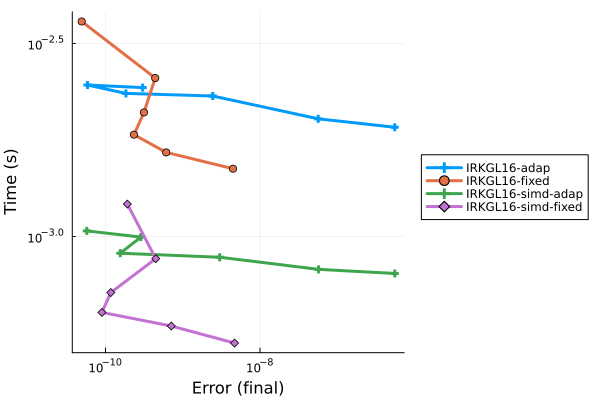

In [13]:
plot(wp0)

In [14]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>Vern9(),:adaptive=>false,:dts=>dts)
           Dict(:alg=>IRKGL16(simd=true),:adaptive=>true) 
           Dict(:alg=>IRKGL16(simd=true),:adaptive=>false,:dts=>dts) 
]
solnames = ["Vern9-adap", "Vern9-fixed", "IRKGL16-simd-adap","IRKGL16-simd-fixed"]
wp1 = WorkPrecisionSet(prob64,abstols,reltols,setups;appxsol=test_sol,names=solnames,
                       save_everystep=false,numruns=100,maxiters=10^9);

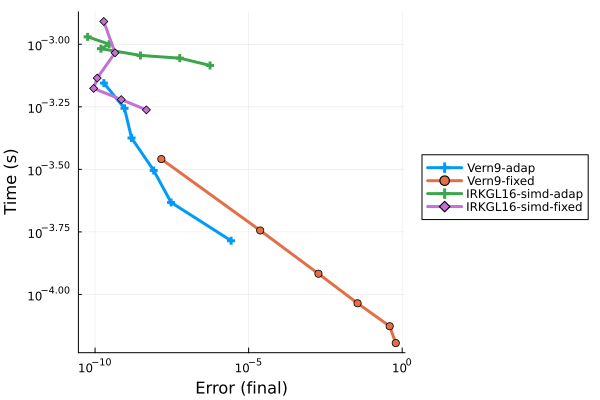

In [15]:
plot(wp1)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

### Computations

In [16]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);
dts=collect(3.1e-3.*(1:length(reltols)));

In [17]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true) 
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts) 
]
solnames = ["Vern9-adap","IRKGL16-adap","IRKGL16-fix"]
wp2 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,
                       names=solnames,save_everystep=false,numruns=10,maxiters=10^9);

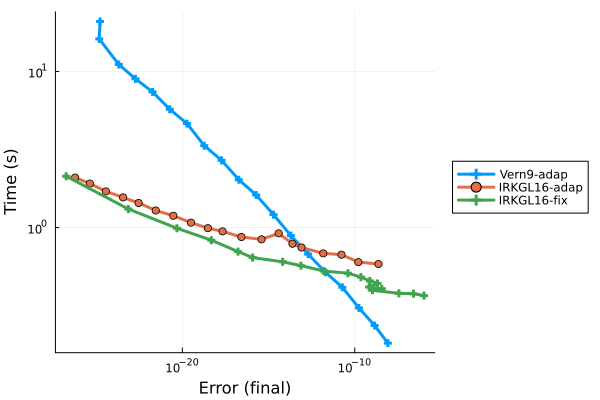

In [18]:
plot(wp2)

<a href="#top">Back to the top</a>